# 01 — Data Acquisition & Processing

**Objective:** Download, clean, and align BTC-USDT perpetual futures trade data from Binance for cross-venue microstructure analysis.

**Pipeline:**
1. Download daily trade data from Binance's public data repository
2. Load and standardise column names
3. Align timestamps to UTC with millisecond precision
4. Classify trade sides (buy/sell) using Binance's `is_buyer_maker` field
5. Compute derived fields: trade sign, log returns, inter-trade durations
6. Run quality checks
7. Save processed data to Parquet format

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path

from src.data import (
    download_binance_trades,
    load_raw_trades,
    standardise_columns,
    align_timestamps,
    classify_trade_side,
    compute_derived_fields,
    run_quality_checks,
    save_processed,
)
from src.visualisation import set_style

set_style()

# Paths
RAW_DIR = Path("../data/raw/binance")
PROCESSED_DIR = Path("../data/processed")

print("Setup complete.")

Setup complete.


## 1. Download Trade Data

We download daily BTC-USDT perpetual futures trade data from [Binance's public data repository](https://data.binance.vision/?prefix=data/futures/um/daily/trades/BTCUSDT/).

Each daily file contains all individual trades with: trade ID, price, quantity, quote quantity, timestamp (Unix ms), and whether the buyer was the maker.

In [2]:
# Download 7 days of recent trade data
# Adjust dates as needed — Binance data is typically available with a 1-2 day lag
END_DATE = (datetime.utcnow() - timedelta(days=2)).strftime("%Y-%m-%d")
START_DATE = (datetime.utcnow() - timedelta(days=8)).strftime("%Y-%m-%d")

print(f"Downloading Binance BTCUSDT perp trades: {START_DATE} to {END_DATE}")

csv_files = download_binance_trades(
    symbol="BTCUSDT",
    start_date=START_DATE,
    end_date=END_DATE,
    output_dir=RAW_DIR,
)

print(f"\nDownloaded {len(csv_files)} files.")
for f in csv_files:
    print(f"  {f.name}")

Downloaded 7 / 7 daily files.

Downloaded 7 files.
  BTCUSDT-trades-2026-01-30.csv
  BTCUSDT-trades-2026-01-31.csv
  BTCUSDT-trades-2026-02-01.csv
  BTCUSDT-trades-2026-02-02.csv
  BTCUSDT-trades-2026-02-03.csv
  BTCUSDT-trades-2026-02-04.csv
  BTCUSDT-trades-2026-02-05.csv


## 2. Load and Standardise

Load all daily CSVs, apply Binance column mapping, and concatenate into a single DataFrame.

In [3]:
dfs = []
for f in csv_files:
    df = load_raw_trades(f, venue="binance")
    df = standardise_columns(df, venue="binance")
    dfs.append(df)

trades = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(trades):,} raw trades across {len(csv_files)} days.")
trades.head()

Loaded 69,445,821 raw trades across 7 days.


,trade_id,price,quantity,quote_qty,timestamp,is_buyer_maker,venue
0,7151642421,84604.7,0.046,3891.8162,1769731200022,True,binance
1,7151642422,84604.7,0.242,20474.3374,1769731200022,True,binance
2,7151642423,84604.7,0.003,253.8141,1769731200022,True,binance
3,7151642424,84604.7,0.039,3299.5833,1769731200022,True,binance
4,7151642425,84604.7,0.003,253.8141,1769731200022,True,binance


## 3. Timestamp Alignment

Convert Unix millisecond timestamps to UTC-aware datetime objects and sort chronologically.

In [4]:
trades = align_timestamps(trades)

print(f"Time range: {trades['timestamp'].min()} → {trades['timestamp'].max()}")
print(f"Total duration: {trades['timestamp'].max() - trades['timestamp'].min()}")
trades[["timestamp", "price", "quantity"]].head()

Time range: 2026-01-30 00:00:00.022000+00:00 → 2026-02-05 23:59:59.951000+00:00
Total duration: 6 days 23:59:59.929000


,timestamp,price,quantity
0,2026-01-30 00:00:00.022000+00:00,84604.7,0.046
1,2026-01-30 00:00:00.022000+00:00,84604.7,0.002
2,2026-01-30 00:00:00.022000+00:00,84604.7,0.033
3,2026-01-30 00:00:00.022000+00:00,84604.7,0.003
4,2026-01-30 00:00:00.022000+00:00,84604.7,0.198


## 4. Trade Side Classification

Binance provides `is_buyer_maker`: if `True`, the buyer was the maker (passive), meaning the trade was initiated by a seller (taker). We map this to:
- `trade_sign = +1` → buyer-initiated (aggressive buy)
- `trade_sign = -1` → seller-initiated (aggressive sell)

In [5]:
trades = classify_trade_side(trades)

buy_count = (trades["trade_sign"] == 1).sum()
sell_count = (trades["trade_sign"] == -1).sum()

print(f"Buy-initiated trades:  {buy_count:>12,} ({buy_count/len(trades):.1%})")
print(f"Sell-initiated trades: {sell_count:>12,} ({sell_count/len(trades):.1%})")

Buy-initiated trades:    34,468,849 (49.6%)
Sell-initiated trades:   34,976,972 (50.4%)


## 5. Derived Fields

Compute:
- **Log returns:** `log(price_t / price_{t-1})` — the standard return measure for high-frequency analysis
- **Inter-trade durations:** milliseconds between consecutive trades — captures trade arrival intensity

In [6]:
trades = compute_derived_fields(trades)

print("Derived field statistics:")
print(f"  Log returns — mean: {trades['log_return'].mean():.2e}, "
      f"std: {trades['log_return'].std():.2e}")
print(f"  Inter-trade duration — median: {trades['inter_trade_duration_ms'].median():.1f} ms, "
      f"mean: {trades['inter_trade_duration_ms'].mean():.1f} ms")

trades[["timestamp", "price", "trade_sign", "log_return", "inter_trade_duration_ms"]].head(10)

Derived field statistics:


  Log returns — mean: -4.28e-09, std: 2.65e-05


  Inter-trade duration — median: 0.0 ms, mean: 8.7 ms


,timestamp,price,trade_sign,log_return,inter_trade_duration_ms
0,2026-01-30 00:00:00.022000+00:00,84604.7,-1,NaN,NaN
1,2026-01-30 00:00:00.022000+00:00,84604.7,-1,0.0,0.0
2,2026-01-30 00:00:00.022000+00:00,84604.7,-1,0.0,0.0
3,2026-01-30 00:00:00.022000+00:00,84604.7,-1,0.0,0.0
4,2026-01-30 00:00:00.022000+00:00,84604.7,-1,0.0,0.0
5,2026-01-30 00:00:00.022000+00:00,84604.7,-1,0.0,0.0
6,2026-01-30 00:00:00.022000+00:00,84604.7,-1,0.0,0.0
7,2026-01-30 00:00:00.022000+00:00,84604.7,-1,0.0,0.0
8,2026-01-30 00:00:00.022000+00:00,84604.7,-1,0.0,0.0
9,2026-01-30 00:00:00.022000+00:00,84604.7,-1,0.0,0.0


## 6. Quality Checks

Systematic checks for data integrity: null values, timestamp gaps, price outliers, and trade sign balance.

In [7]:
quality = run_quality_checks(trades, venue="binance")

print("=" * 50)
print("DATA QUALITY REPORT — Binance BTCUSDT Perpetual")
print("=" * 50)
for key, value in quality.items():
    print(f"  {key:.<35} {value}")
print("=" * 50)

DATA QUALITY REPORT — Binance BTCUSDT Perpetual
  venue.............................. binance
  total_trades....................... 69445821
  date_range_start................... 2026-01-30 00:00:00.022000+00:00
  date_range_end..................... 2026-02-05 23:59:59.951000+00:00
  null_prices........................ 0
  null_quantities.................... 0
  null_trade_signs................... 0
  unique_dates....................... 7
  gaps_over_1min..................... 0
  max_gap_seconds.................... 5.955
  price_min.......................... 62233.3
  price_max.......................... 84697.2
  price_mean......................... 75102.80472742341
  buy_fraction....................... 0.4963415869185275
  sell_fraction...................... 0.5036584130814725


## 7. Visualisation — Quick Sanity Checks

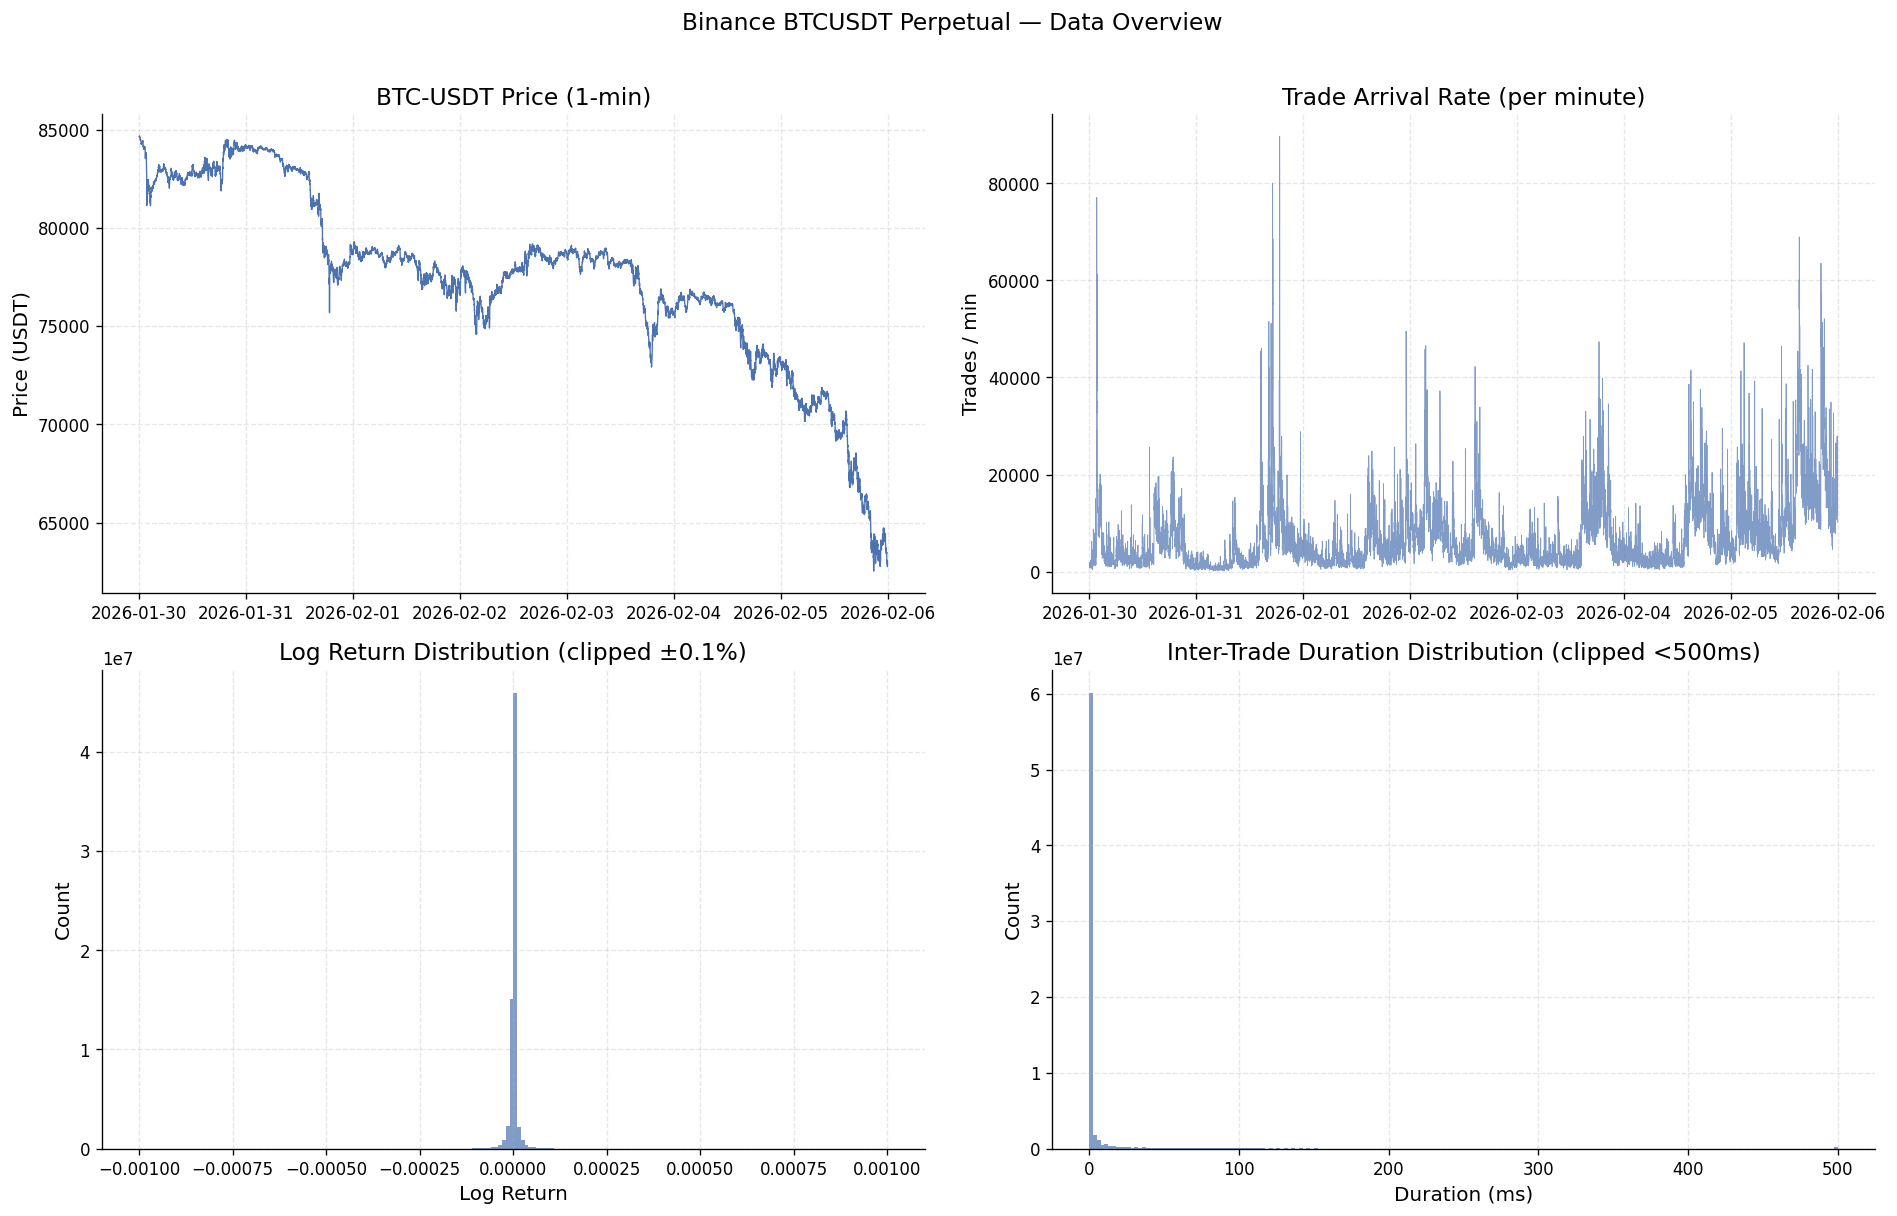

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (a) Price over time — resample to 1-min for readability
price_1min = trades.set_index("timestamp")["price"].resample("1min").last().dropna()
axes[0, 0].plot(price_1min.index, price_1min.values, linewidth=0.8)
axes[0, 0].set_title("BTC-USDT Price (1-min)")
axes[0, 0].set_ylabel("Price (USDT)")

# (b) Trade arrival rate — trades per minute
arrival = trades.set_index("timestamp").resample("1min").size()
axes[0, 1].plot(arrival.index, arrival.values, linewidth=0.5, alpha=0.7)
axes[0, 1].set_title("Trade Arrival Rate (per minute)")
axes[0, 1].set_ylabel("Trades / min")

# (c) Log return distribution
returns_clean = trades["log_return"].dropna()
axes[1, 0].hist(returns_clean.clip(-0.001, 0.001), bins=200, edgecolor="none", alpha=0.7)
axes[1, 0].set_title("Log Return Distribution (clipped ±0.1%)")
axes[1, 0].set_xlabel("Log Return")
axes[1, 0].set_ylabel("Count")

# (d) Inter-trade duration distribution
durations = trades["inter_trade_duration_ms"].dropna()
axes[1, 1].hist(durations.clip(0, 500), bins=200, edgecolor="none", alpha=0.7)
axes[1, 1].set_title("Inter-Trade Duration Distribution (clipped <500ms)")
axes[1, 1].set_xlabel("Duration (ms)")
axes[1, 1].set_ylabel("Count")

for ax in axes.flat:
    ax.grid(True, alpha=0.3)

fig.suptitle("Binance BTCUSDT Perpetual — Data Overview", fontsize=14, y=1.01)
fig.tight_layout()
plt.show()

## 8. Intraday Patterns

Examine how trading activity varies by hour of day — important context for later entropy analysis.

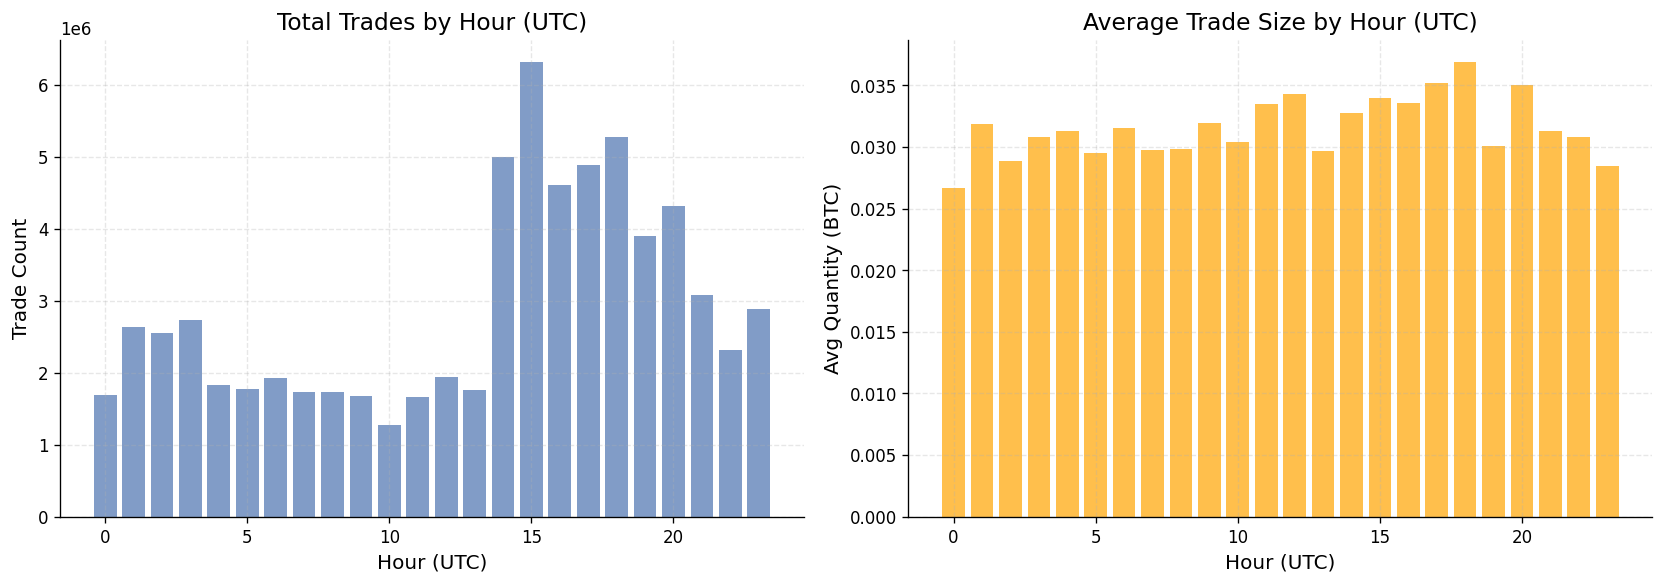

In [9]:
trades["hour"] = trades["timestamp"].dt.hour

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trades per hour
hourly_counts = trades.groupby("hour").size()
axes[0].bar(hourly_counts.index, hourly_counts.values, alpha=0.7)
axes[0].set_title("Total Trades by Hour (UTC)")
axes[0].set_xlabel("Hour (UTC)")
axes[0].set_ylabel("Trade Count")

# Average trade size by hour
hourly_size = trades.groupby("hour")["quantity"].mean()
axes[1].bar(hourly_size.index, hourly_size.values, alpha=0.7, color="orange")
axes[1].set_title("Average Trade Size by Hour (UTC)")
axes[1].set_xlabel("Hour (UTC)")
axes[1].set_ylabel("Avg Quantity (BTC)")

fig.tight_layout()
plt.show()

# Drop the helper column
trades = trades.drop(columns=["hour"])

## 9. Save Processed Data

Save the cleaned, processed DataFrame to Parquet for efficient loading in subsequent notebooks.

In [10]:
save_processed(trades, PROCESSED_DIR / "binance_btcusdt_perp.parquet")

print(f"\nFinal dataset shape: {trades.shape}")
print(f"Columns: {list(trades.columns)}")
print(f"Memory usage: {trades.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Saved 69,445,821 trades to ../data/processed/binance_btcusdt_perp.parquet

Final dataset shape: (69445821, 10)
Columns: ['trade_id', 'price', 'quantity', 'quote_qty', 'timestamp', 'is_buyer_maker', 'venue', 'trade_sign', 'log_return', 'inter_trade_duration_ms']
Memory usage: 5564.3 MB


## Summary

**What we have:**
- 7 days of BTC-USDT perpetual futures trade data from Binance
- Each trade tagged with: price, quantity, UTC timestamp, trade sign, log return, and inter-trade duration
- Data saved as Parquet for fast loading in subsequent analysis

**Next:** Notebook 02 — Exploratory Microstructure Analysis (trade sign ACF, cross-venue correlations, venue characteristics).